In [1]:
import sys
import os
import random
import math
import copy
import time
import numpy as np
from scipy.io import loadmat
from pathlib import Path

In [2]:
# for plotting
import matplotlib
# matplotlib.use('TkAgg') 
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import matplotlib.patches as mpatches

sns.set()
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=4, rc={"lines.linewidth": 4})
mpl.rcParams['lines.linewidth'] = 3
plt.rcParams['axes.unicode_minus'] = False

In [3]:
def to_str(x, fmt):
    y = []
    for i in x:
        y.append(fmt % i)
    return y

In [4]:
oed_dir = '../oed_calculations/results/SNR_2_NGauss_5_NumberUncertain_3_Nscans_30_optim_FA_const_design_update_kpl_all_domain/' #_kpl_all_domain/'
num_trials = 25
num_scans = 30
rel_noise = 1
num_rec_param = 1
SNR_data_vec = [2, 5, 10, 15, 20]

npzfile = np.load('new_voxel_sorting_data.npz', allow_pickle=True)

xroi = npzfile['xroi']
yroi = npzfile['yroi']
zroi = npzfile['zroi']
#n_roi = len(xroi)

voxel_clusters = npzfile['clusters']
voxel_clusters_peak_pyr = npzfile['clusters_pyr_peak_v']
voxel_clusters_range = npzfile['clusters_range']

# voxel_clusters_range[3, 1] = 0

xroi, yroi, zroi, voxel_clusters, voxel_clusters_peak_pyr, voxel_clusters_range



(array([ 9,  7, 15, 15, 12,  7,  8,  2,  4, 14, 13, 13,  9, 14,  9,  7, 13,
         6,  8,  3,  5,  9, 10,  2,  8]),
 array([ 4, 15,  8,  8, 12,  9, 13,  9,  7, 13,  5,  8, 10,  6,  9,  9, 14,
         8,  2,  9,  5,  9,  6,  8, 13]),
 array([14,  7,  6,  6, 11,  7,  7,  8,  9, 10,  8,  7, 12,  9, 12,  9,  6,
         8, 11, 12,  8,  8,  7,  7, 10]),
 array([list([0, 1, 2, 3, 4, 5, 6]),
        list([7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]),
        list([19, 20, 21, 22]), list([23, 24])], dtype=object),
 array([array([0.2382911 , 0.2378429 , 0.2199994 , 0.2199994 , 0.19226095,
               0.17040558, 0.17024441])                                   ,
        array([0.08152726, 0.06877422, 0.05961734, 0.0581922 , 0.05637883,
               0.04351823, 0.04005542, 0.02465373, 0.02431826, 0.0219304 ,
               0.01324567, 0.01268962])                                   ,
        array([0.0050148 , 0.00487458, 0.00219746, 0.00203031]),
        array([0.00093979, 0.00073837])], 

In [5]:
sdt_levels = voxel_clusters_range
pix_levels = [[1, voxel_clusters[0][-1]+1], \
              [voxel_clusters[1][0]+1, voxel_clusters[1][-1]+1], \
              [voxel_clusters[2][0]+1, voxel_clusters[2][-1]+1], \
              [voxel_clusters[3][0]+1, voxel_clusters[3][-1]+1]]
sdt_levels, pix_levels

(array([[1.e+00, 1.e-01],
        [1.e-01, 1.e-02],
        [1.e-02, 1.e-03],
        [1.e-03, 1.e-05]]),
 [[1, 7], [8, 19], [20, 23], [24, 25]])

# Read voxel-wise data

In [17]:
def fname_base():
    return    oed_dir \
            + 'HF_recover_NumRecoverParams_%d_NumTrials_%d_Rel_Noise_%d/' \
                % (num_rec_param, num_trials, rel_noise)

def fname_snr(snr_i):
    return    oed_dir \
            + 'HF_recover_NumRecoverParams_%d_NumTrials_%d_Rel_Noise_%d/SNR_data_%d/' \
                % (num_rec_param, num_trials, rel_noise, SNR_data_vec[snr_i])

def fname_vox(snr_i, vox_j):
    return    oed_dir \
            + 'HF_recover_NumRecoverParams_%d_NumTrials_%d_Rel_Noise_%d/SNR_data_%d/voxel_%d/recover.mat' \
                % (num_rec_param, num_trials, rel_noise, SNR_data_vec[snr_i], vox_j)

def fname_vox_true(snr_i, vox_j):
    return    oed_dir \
            + 'HF_recover_NumRecoverParams_%d_Rec_True/No_noise/voxel_%d/recover.mat' \
                % (num_rec_param, vox_j)

def fname_all_vox(snr_i):
    f = []
    for i in range(25):
        f.append(fname_vox(snr_i, i+1))
    return f

def fname_all_vox_true(snr_i):
    f = []
    for i in range(25):
        f.append(fname_vox_true(snr_i, i+1))
    return f

def fdata_vox(f):
    data = loadmat(f)
    rec_params = data['rec_params']
    mean = data['params_mean'][0][0]
    var = data['params_var'][0][0]
    std = data['params_std'][0][0]
    rec_true = data['params_true'][0][0]
    return mean, var, std, rec_params, rec_true

def fdata_vox_all(f):
    for i in range(len(f)):
        if i == 0:
            mean, var, std, rec_params, params_true = fdata_vox(f[i])
        else:
            a, b, c, d, e = fdata_vox(f[i])
            mean = mean + a
            var = var + b
            std = std + c
            rec_params = rec_params + d
            params_true = params_true + e
            
    return mean, var, std, rec_params, params_true

In [7]:
mean, var, std, rec_params, rec_true = fdata_vox(fname_vox(0, 1))

/Users/prashant/opt/anaconda3/envs/confen/lib/python3.8/site-packages/scipy/io/matlab/_mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [8]:
data = loadmat(fname_vox(0, 1))
rec_params = data['rec_params']
np.shape(rec_params), rec_params, rec_params[0,0,0]

((26, 1, 25),
 array([[[0.10325424, 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ]],
 
        [[0.13498531, 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ]],
 
        [[0.12602878, 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        

# Store voxel-wise data as a single numpy data 

In [18]:
# get data for all SNR_vec
mean_data, var_data, std_data, params_rec_data, params_true_data = [], [], [], [], []
tag_data = []
N_SNR_data = len(SNR_data_vec)
for s in range(N_SNR_data):
    fs = fname_all_vox(s)
    a, b, c, d, e = fdata_vox_all(fs)
    mean_data.append(a)
    var_data.append(b)
    std_data.append(c)
    params_rec_data.append(d)
    params_true_data.append(e)

    tag_data.append(r'SNR = ' + '{}'.format(SNR_data_vec[s]))# + r' (data)')

In [19]:
# Save this data
fbase = fname_base()
npz_file_rec = fbase + 'recover_all_snr_all_voxels.npz'
np.savez(npz_file_rec, mean_data = mean_data, var_data = var_data, \
                 std_data = std_data, params_rec_data = params_rec_data, params_true_data = params_true_data, \
                 tag_data = tag_data)

# Plot OED results

In [21]:
# read data
fbase = fname_base()
npz_file_rec = fbase + 'recover_all_snr_all_voxels.npz'
npzfile_rec = np.load(npz_file_rec, allow_pickle=True)

mean_data = npzfile_rec['mean_data']
var_data = npzfile_rec['var_data']
std_data = npzfile_rec['std_data']
params_rec_data = npzfile_rec['params_rec_data']
params_true_data = npzfile_rec['params_true_data']
tag_data = npzfile_rec['tag_data']

[]

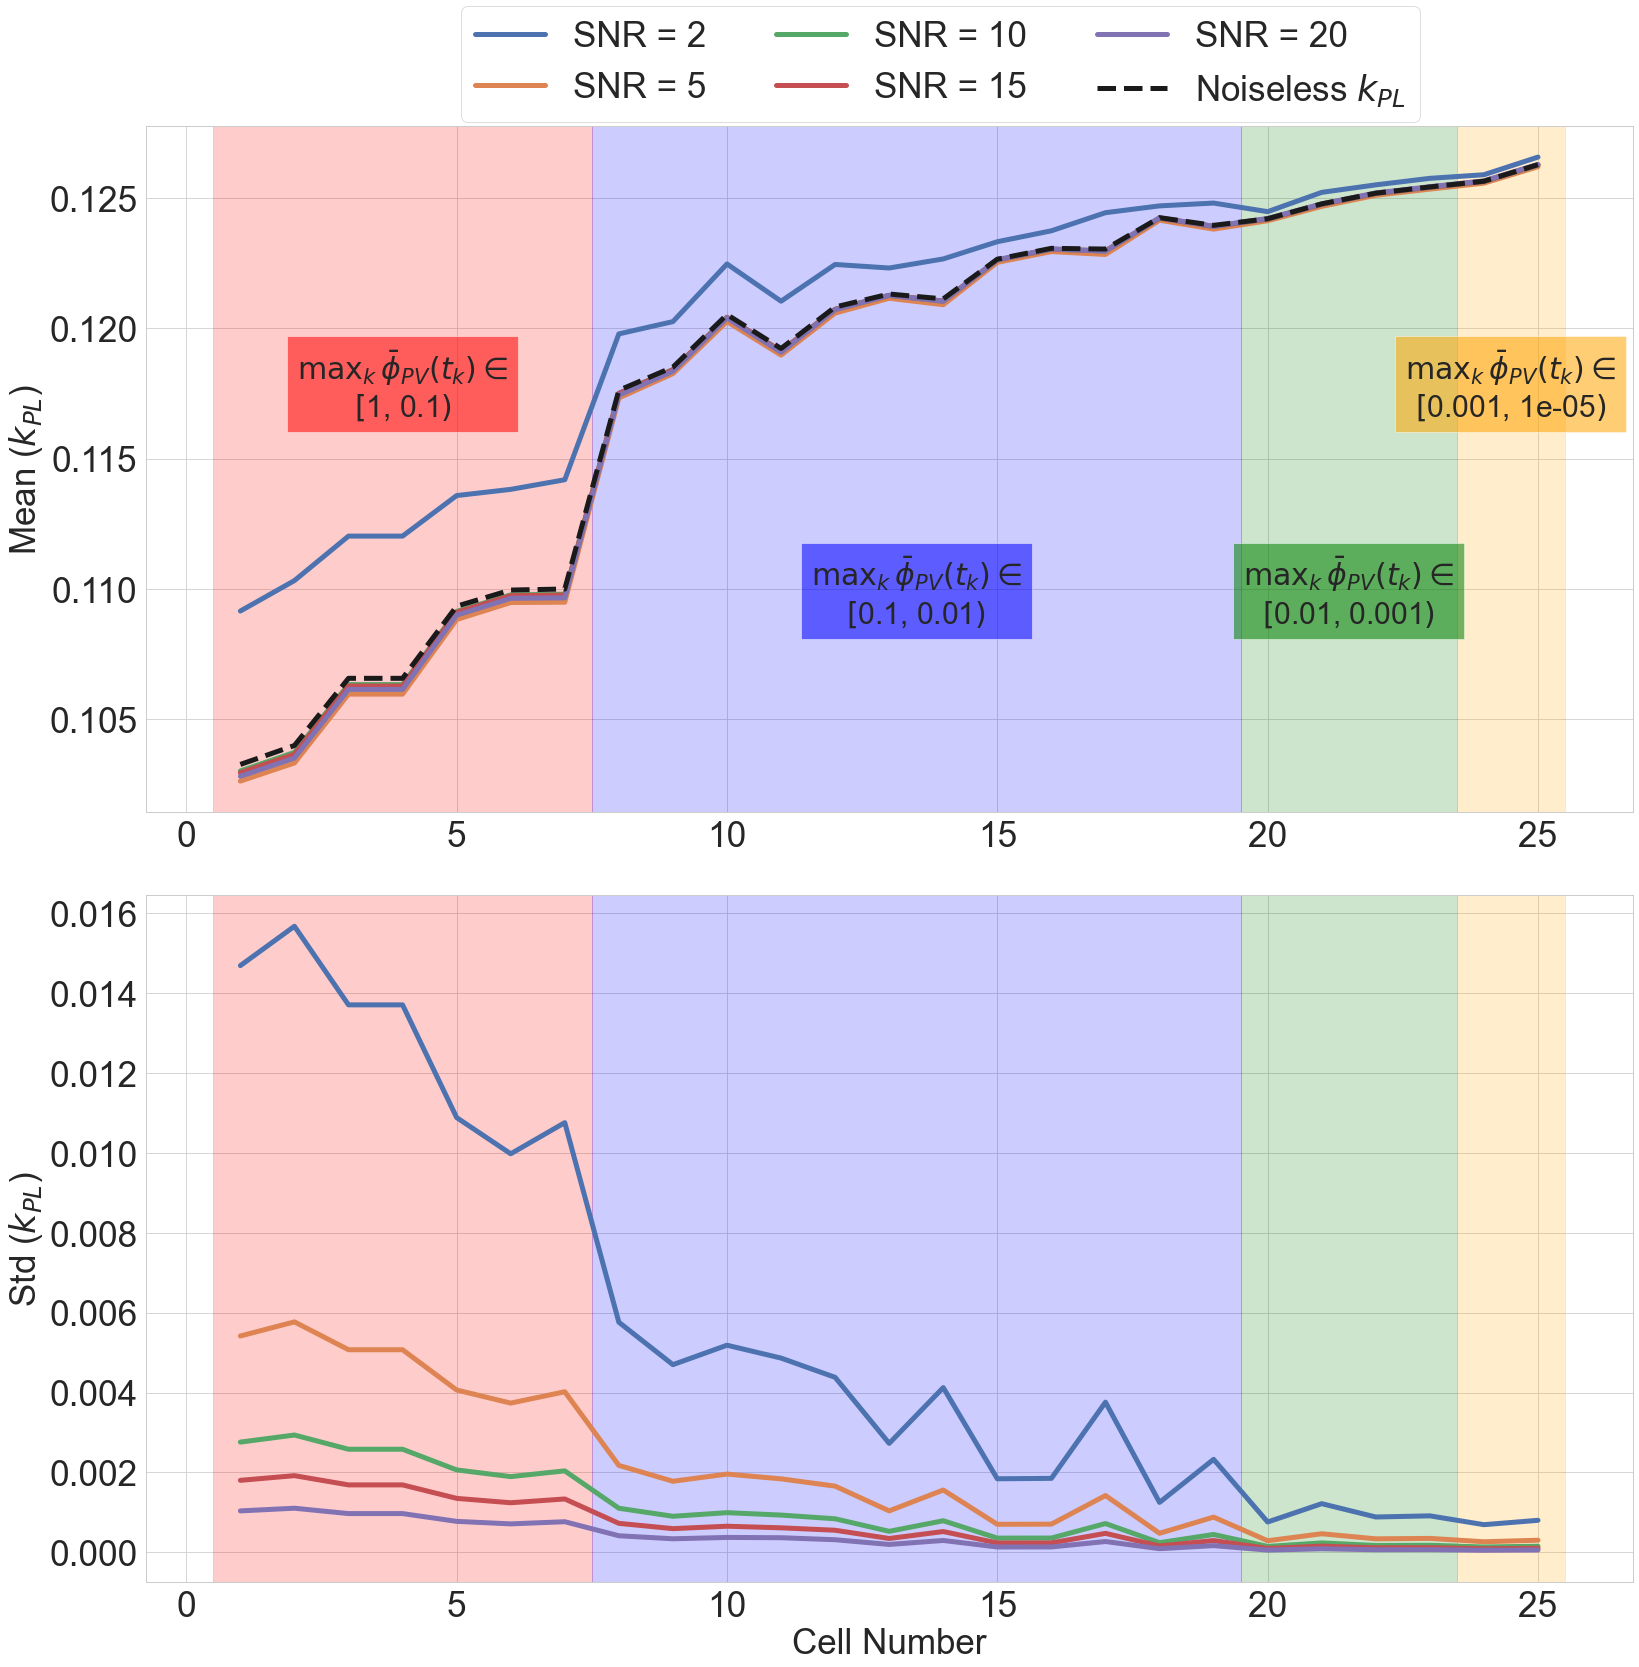

In [24]:
save_fig = True
pdf_fname = 'voxel_recovery_plot_update_kpl_all_domain'

#plot
nrows = 2
ncols = 1
figsize = [12, 24]
fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize = (nrows*figsize[0],ncols*figsize[1]))
labelfs = 35
box_labelfs = 30
lw = 5
ms = 50

# find number of voxels
N_voxels = len(mean_data[0])
voxel_ids = np.array([i+1 for i in range(N_voxels)])
true_kpl = params_true_data[0]

# get upper and lower bound of the data
true_kpl_max = np.max(true_kpl)
true_kpl_min = np.min(true_kpl)
mean_min = np.min([np.min(mean_data[i]) for i in range(N_SNR_data)])
mean_max = np.max([np.max(mean_data[i]) for i in range(N_SNR_data)])
if mean_max < 0.1:
    mean_max = 0.1
if mean_min > 0.1:
    mean_min = 0.1
if mean_max < true_kpl_max:
    mean_max = true_kpl_max
if mean_min > true_kpl_min:
    mean_min = true_kpl_min    

var_min = np.min([np.min(var_data[i]) for i in range(N_SNR_data)])
var_max = np.max([np.max(var_data[i]) for i in range(N_SNR_data)])

std_min = np.min([np.min(std_data[i]) for i in range(N_SNR_data)])
std_max = np.max([np.max(std_data[i]) for i in range(N_SNR_data)])

# loop over SNRs and plot mean and std
for j_snr in range(N_SNR_data):
    #if j_snr == 0:
        #ax[0].plot(voxel_ids, true_kpl, linewidth=lw)
        
    ax[0].plot(voxel_ids, mean_data[j_snr], label='{}'.format(tag_data[j_snr]), linewidth=lw)
    ax[1].plot(voxel_ids, std_data[j_snr], label='{}'.format(tag_data[j_snr]), linewidth=lw)
    
# true kpl
ax[0].plot(voxel_ids, true_kpl, 'k--', label = r'Noiseless $k_{PL}$', linewidth=lw)

# vertical axis label only on first column
ax[0].set_ylabel(r'Mean ($k_{PL}$)', fontsize = labelfs)
ax[1].set_ylabel(r'Std ($k_{PL}$)', fontsize = labelfs)

# horizontal axis label on last row
ax[1].set_xlabel(r'Cell Number', fontsize = labelfs)

# create zones seperating voxels
sdt_levels = voxel_clusters_range
pix_levels = [[1, voxel_clusters[0][-1]+1], \
              [voxel_clusters[1][0]+1, voxel_clusters[1][-1]+1], \
              [voxel_clusters[2][0]+1, voxel_clusters[2][-1]+1], \
              [voxel_clusters[3][0]+1, voxel_clusters[3][-1]+1]]
fact_y_text_levels = [1.04, 0.97, 0.97, 1.04]
col_levels = ['red', 'blue', 'green', 'orange', 'cyan']
col_box_levels = col_levels
for i in range(2):
    for j in range(len(pix_levels)):
        sl, su = sdt_levels[j]
        pl, pu = pix_levels[j]
        x_text, y_text = 0.5 * (pl + pu), 0.5 * (mean_min+mean_max) * fact_y_text_levels[j]
        if i == 1:
            y_text = 0.5 * (std_min+std_max) * fact_y_text_levels[j]

        # distance range
        sdt_text = r'$\mathrm{max}_k\,\bar{\phi}_{PV}(t_k) \in$' + '\n' + '$[$' + '%g' % sl + ', %g' % su + r'$)$'
        #if j == 0:
        #    sdt_text = r'$\mathrm{sdt} \in [0$' + ', %4.2f' % su + r'$]$'

        # plot rectange
        ax[i].axvspan(pl-0.5, pu+0.5, alpha=0.2, color=col_levels[j])

        # add text only on the (row1, col1) plot
        if i == 0:
            ax[i].text(x_text, y_text, \
                   sdt_text, \
                   ha='center', va = 'center', fontsize=box_labelfs, \
                   bbox={'facecolor': col_box_levels[j], 'alpha': 0.55, 'pad': 10})

lgd = ax[0].legend(fancybox=True, fontsize=labelfs, ncol = 3, bbox_to_anchor=(0.2, 1.09), loc='center left')
#lgd = ax[0].legend(fancybox=True, fontsize=labelfs, ncol = 2, loc = 'lower center')
        
plt.tight_layout()
if save_fig:
    plt.savefig(pdf_fname + '.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.plot()

In [5]:
# scratch

In [9]:
a = np.random.randn(2,4)
b = np.random.randn(2,4)
a, b

(array([[ 0.8955336 ,  0.44562728,  1.20012004,  1.0576038 ],
        [ 0.88977283, -2.08971959, -1.59535448,  0.94505408]]),
 array([[ 0.46582295,  0.54457255, -0.1775449 , -0.28367636],
        [ 0.50497402, -0.78633237,  0.08982711, -2.06095806]]))

In [11]:
a = a+b
a

array([[ 1.36135656,  0.99019983,  1.02257514,  0.77392743],
       [ 1.39474685, -2.87605197, -1.50552737, -1.11590397]])